In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df = pd.read_csv('../terraforming-mars-stats.csv')
unique_sorted_game_ids = pd.Series([x for _,x in sorted(zip(df.date, df.game_id), reverse=True)]).unique() # for time-based stuff

In [10]:
{game_id: i+1 for i, game_id in enumerate(unique_sorted_game_ids)}

{-5087687828506643008: 1,
 -480900618884244002: 2,
 9160670357196963251: 3,
 -4457686082031944754: 4,
 -2724479498139867643: 5,
 8411001116994680649: 6,
 6314213421815839348: 7,
 5364031787654076444: 8,
 5124442952666303560: 9,
 -8115731792273778360: 10,
 -2856292396473150394: 11,
 -1275914559459940408: 12,
 -4288835453309782069: 13,
 -8063961042303797267: 14,
 -4169925887049832394: 15,
 7431242073840270607: 16,
 1333226272161471682: 17,
 -1160215640699003942: 18,
 -4624666908656841204: 19,
 5772081591309178204: 20,
 7856015573055090963: 21,
 -8568936371923742741: 22,
 391202894794614223: 23,
 -4653188484514658833: 24,
 -4298143714142509775: 25,
 -1737535016708489410: 26,
 245438697050250684: 27,
 -2770716056065863656: 28,
 2262825929104772499: 29,
 -102156762050159202: 30,
 8399442153451307441: 31,
 5309125977277424018: 32,
 2584195405845979693: 33,
 -1310296222503061703: 34,
 7811474385287870106: 35,
 134527730090413700: 36,
 -3726172732226663983: 37,
 -3421534681791140808: 38,
 3190

# Summary

In [24]:
df.groupby('player').\
agg(wins = ('is_winner','sum'), games = ('is_winner', 'count'), win_rate = ('is_winner','mean')).\
sort_values(by='win_rate', ascending=False)

,wins,games,win_rate
player,,,
Meister,1,1,1.000000
Pat,26,71,0.366197
Ezra,38,105,0.361905
Ben,52,146,0.356164
Tony,31,107,0.289720
Matt,35,122,0.286885
Katie,1,4,0.250000
Annie,0,1,0.000000
Hank,0,1,0.000000


# Individual Player Summary

In [25]:
player = 'Tony'
player_df = df[df.player == player]

In [26]:
# player history
player_df.groupby('player').\
agg(wins = ('is_winner','sum'), games = ('is_winner', 'count'), win_rate = ('is_winner','mean'))

,wins,games,win_rate
player,,,
Tony,31,107,0.28972


In [27]:
# most recent win
player_df[player_df['is_winner']==1].sort_values(by='date', ascending=False).head(1)

,player,game_id,date,num_players,board,prelude,venus,colonies,turmoil,bgg,...,award_2_points,award_3_points,milestone_1_points,milestone_2_points,milestone_3_points,total_points,total_percent_of_points,point_diff,is_winner,place
8,Tony,9160670357196963251,2021-11-16,3,Tharsis,1,0,0,1,0,...,2.0,5.0,5.0,NaN,NaN,86,38.914027,0,1,1.0


# Player ELO

In [28]:
# https://towardsdatascience.com/developing-a-generalized-elo-rating-system-for-multiplayer-games-b9b495e87802

# scoring functions
def linear_score(p, n):
    '''
    Args:
        p : int 
            Finishing place
        n : int 
            # of players
    '''
    return (n-p)/ (n*(n-1)/2)

def exp_score(p, n, alpha=2.):
    '''
    Args:
        p : int 
            Finishing place
        n : int 
            # of players
        alpha : exists in (1,inf)'''
    return (alpha**(n-p) - 1) / np.sum([(alpha**(n-i) - 1) for i in range(1,n)])

# expected score
def expected_score(s, player, n, d=400):
    '''
    Args:
        s : dict
            Players scores, ex.: {'Tony': 90, 'Pat': 80, ...}
        player : str
            Player of interest
        n : int 
            # of players
    '''
    return np.sum([(1/(1+10**((s[i] - s[player])/d))) if i != player else 0 for i in s.keys()])/(n*(n-1)/2)

def update_rating(current_rating, expected_score, actual_score, n, k=32):
    '''
    Args:
        current_rating : int
        expected_score : float
        actual_score : float
        n : int
            # of players
        k : int
    '''
    return current_rating + k*(n-1)*(actual_score-expected_score)

In [29]:
player_ratings = {player: {1: {'date':(min(pd.to_datetime(df.date)) - pd.Timedelta(days=1)),
                               'rating':1000}} for player in df.player.unique()}
current_ratings = {player: 1000 for player in df.player.unique()}
i = 2

for game_id in unique_sorted_game_ids:
    game_df = df[df['game_id'] == game_id]
    
    new_ratings = {}
    current_ratings_active_players = {player: rating for player, rating in current_ratings.items() if player in game_df.player.unique()}

    for player, place, date in zip(game_df.player, game_df.place, game_df.date):
        expected = expected_score(s=current_ratings_active_players, player=player, n=game_df.shape[0])
        observed = exp_score(p=place, n=game_df.shape[0])
        updated =  update_rating(current_rating=current_ratings_active_players[player], 
                                 expected_score=expected, 
                                 actual_score=observed, 
                                 n=game_df.shape[0])
        new_ratings[player] = {'previous': current_ratings_active_players[player],
                               'expected': expected,
                               'observed': observed,
                               'updated_rating': updated}

    for player in current_ratings.keys():
            if player in new_ratings.keys(): # player played in current game
                current_ratings[player] = new_ratings[player]['updated_rating']
                player_ratings[player][i] = {'date': pd.to_datetime(date), 'rating': new_ratings[player]['updated_rating']}
            else: # player did not play in current game
                player_ratings[player][i] = {'date': pd.to_datetime(date), 'rating': current_ratings[player]}
    
    i += 1
    
player_rating_dfs_list = [pd.DataFrame(player_ratings[player]).T.reset_index().assign(player=player)\
                          for player in player_ratings.keys()]
player_ratings_df = pd.concat(player_rating_dfs_list)
player_ratings_df.columns = ['game_number','date','rating','player']


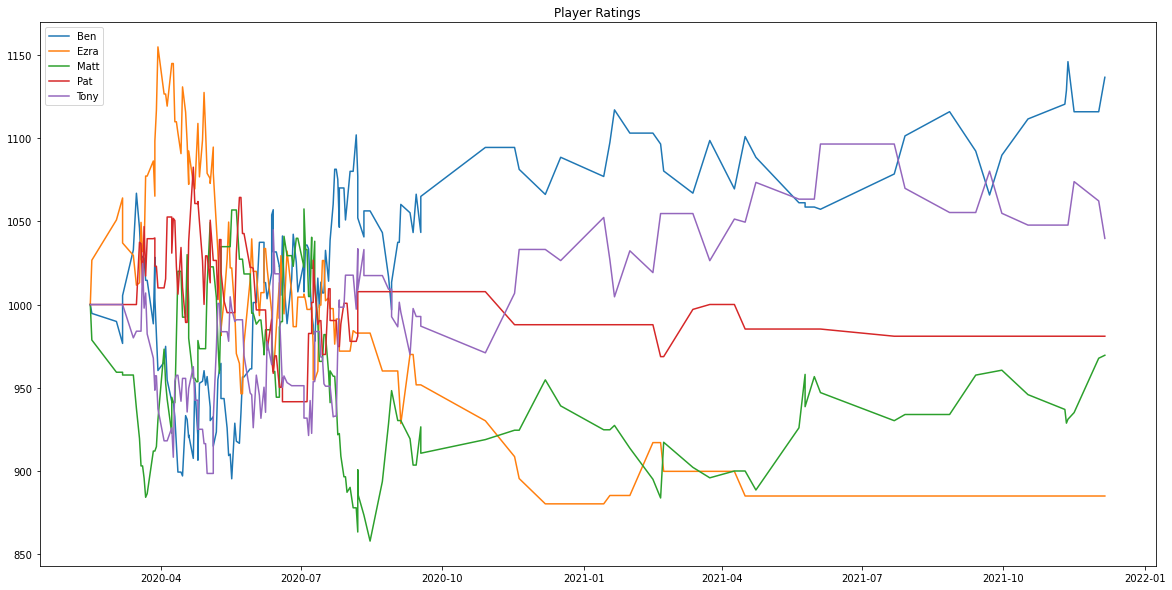

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

for player in ['Ben','Ezra','Matt','Pat','Tony']:#player_ratings_df.player.unique():
    player_rating_df = player_ratings_df[player_ratings_df['player']==player]
    ax.plot(player_rating_df.date, player_rating_df.rating, label=player)
ax.legend()
ax.set_title('Player Ratings');

# Corporation ELO

In [ ]:
corp_ratings = {corp: {1: {'date':(min(pd.to_datetime(df.date)) - pd.Timedelta(days=1)),
                             'rating':1000}} for corp in df.corporation.unique()}
current_ratings = {corp: 1000 for corp in df.corporation.unique()}
i = 2

for game_id in unique_sorted_game_ids:
    game_df = df[df['game_id'] == game_id]
    game_df['place'] = game_df['total_points'].rank(ascending=False)
    
    new_ratings = {}
    current_ratings_active_corps = {corp: rating for corp, rating in current_ratings.items() if corp in game_df.corporation.unique()}

    for corp, place, date in zip(game_df.corporation, game_df.place, game_df.date):
        expected = expected_score(s=current_ratings_active_corps, player=corp, n=game_df.shape[0])
        observed = linear_score(p=place, n=game_df.shape[0])
        updated =  update_rating(current_rating=current_ratings_active_corps[corp], 
                                 expected_score=expected, 
                                 actual_score=observed, 
                                 n=game_df.shape[0])
        new_ratings[corp] = {'previous': current_ratings_active_corps[corp],
                               'expected': expected,
                               'observed': observed,
                               'updated_rating': updated}

    for corp in current_ratings.keys():
            if corp in new_ratings.keys(): # corp played in current game
                current_ratings[corp] = new_ratings[corp]['updated_rating']
                corp_ratings[corp][i] = {'date': pd.to_datetime(date), 'rating': new_ratings[corp]['updated_rating']}
            else: # corp did not play in current game
                corp_ratings[corp][i] = {'date': pd.to_datetime(date), 'rating': current_ratings[corp]}
    
    i += 1
    
corp_rating_dfs_list = [pd.DataFrame(corp_ratings[corp]).T.reset_index().assign(corporation=corp)\
                          for corp in corp_ratings.keys()]
corp_ratings_df = pd.concat(corp_rating_dfs_list)
corp_ratings_df.columns = ['game_number','date','rating','corporation']


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,15))

for corp in set(df[df.corporation_origin=='Base'].corporation.unique()) - set(['Beginner']):
    corp_rating_df = corp_ratings_df[corp_ratings_df['corporation']==corp][1:100]
    ax.plot(corp_rating_df.date, corp_rating_df.rating, label=corp)
ax.legend()
ax.set_title('Corporation Ratings');